In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import ResNet50, VGG16, EfficientNetB0
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import random
from keras import Input, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.applications.resnet import preprocess_input as resnet_preprocess
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.applications.efficientnet import preprocess_input as effnet_preprocess


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = r'C:\Users\sophi\OneDrive\Desktop\TuberculosisDetection\Dataset of Tuberculosis Chest X-rays Images' # e.g., './dataset/'
CATEGORIES = ['Normal Chest X-rays', 'TB Chest X-rays']
IMG_SIZE = 224 # Image size for models like ResNet50, VGG16
BATCH_SIZE = 32

In [5]:
# --- Loading Data ---
def load_data(data_dir, img_size, categories):
    """Loads images and labels from the specified directory."""
    data = []
    labels = []
    for category_id, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        for img_path in os.listdir(path):
            try:
                img_array = tf.keras.preprocessing.image.load_img(
                    os.path.join(path, img_path),
                    target_size=(img_size, img_size)
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                data.append(img_array)
                labels.append(category_id)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(data), np.array(labels)

In [6]:
# --- Load and Split Data ---
images, labels = load_data(DATA_DIR, IMG_SIZE, CATEGORIES)

In [7]:
# Normalize pixel values to be between 0 and 1
images = images / 255.0

In [8]:
# Split data into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Split temp data into validation (50% of temp -> 10% of total) and test (50% of temp -> 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training images: {X_train.shape}")
print(f"Validation images: {X_val.shape}")
print(f"Test images: {X_test.shape}")

Training images: (2406, 224, 224, 3)
Validation images: (301, 224, 224, 3)
Test images: (301, 224, 224, 3)


In [9]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

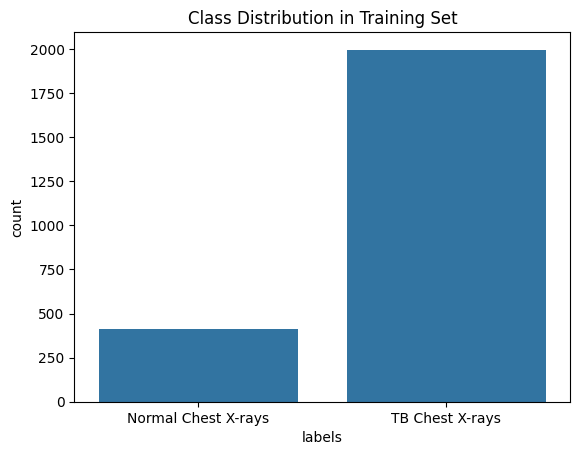

In [10]:
# --- Class Distribution ---
df_labels = pd.DataFrame({'labels': y_train})
sns.countplot(x='labels', data=df_labels)
plt.title("Class Distribution in Training Set")
plt.xticks(ticks=[0, 1], labels=CATEGORIES)
plt.show()

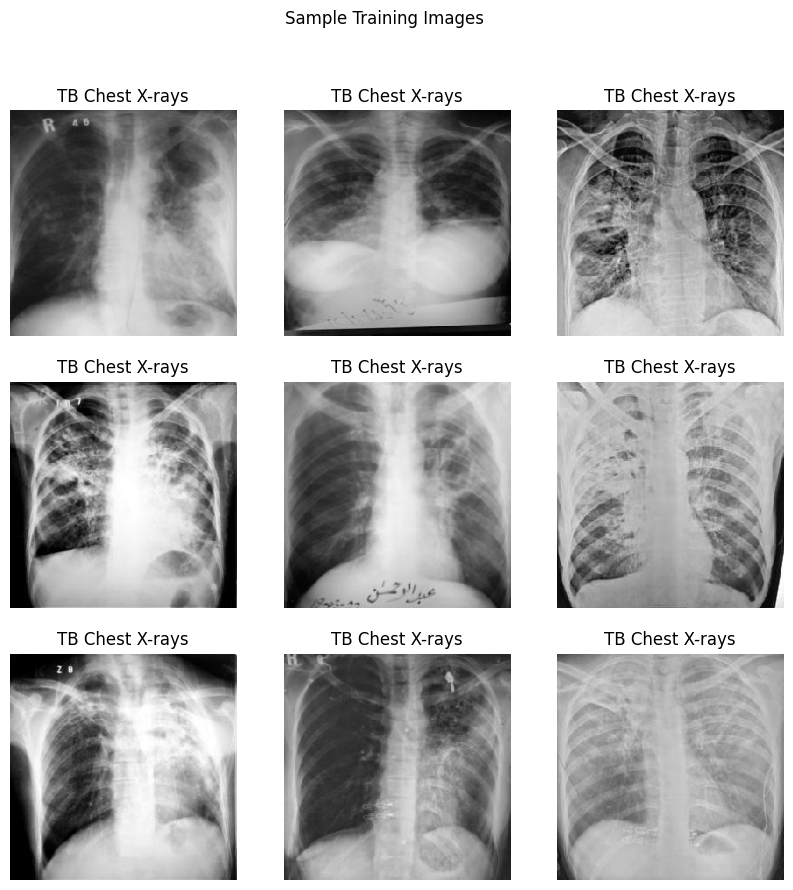

In [11]:
# --- Display Sample Images ---
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(CATEGORIES[y_train[i]])
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

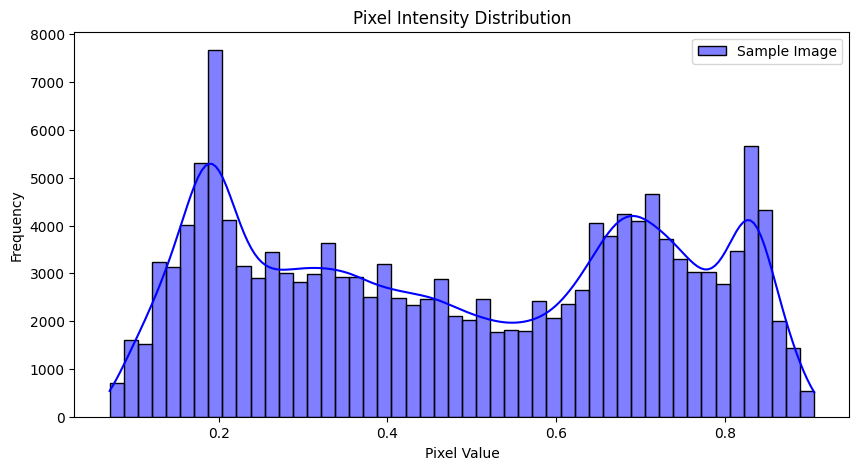

In [12]:
# --- Pixel Intensity Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(X_train[0].flatten(), color='blue', label='Sample Image', kde=True)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# --- Model Configuration ---
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [27]:
from kerastuner import HyperParameters
# Custom F1-Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

hp = HyperParameters()

def build_model(base_model_name, input_shape=(224, 224, 3)):
    """Factory function to build different transfer learning models"""
    # Create base model
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    hp_units = hp.Int(f'units_{base_model_name}', min_value=512, max_value=2048, step=256)
    hp_dropout = hp.Float(f'dropout_{base_model_name}', min_value=0.1, max_value=0.3, step=0.1)
    hp_learning_rate = hp.Choice(f'learning_rate_{base_model_name}', values=[1e-2, 1e-3, 1e-4])

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )

    return model

# Prepare validation data for ROC callback
val_data = next(iter(val_ds))

# Train multiple models
models = {
    'ResNet50': build_model('ResNet50'),
    'VGG16': build_model('VGG16'),
    'EfficientNetB0': build_model('EfficientNetB0')
}

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

history = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    history[name] = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks = callbacks
    )
    model.save(f"{name}.keras")


Training ResNet50...
Epoch 1/30
76/76 [==============================] - 140s 2s/step - loss: 0.6697 - accuracy: 0.8213 - precision: 0.8300 - recall: 0.9865 - f1_score: 0.9015 - val_loss: 0.4539 - val_accuracy: 0.8306 - val_precision: 0.8306 - val_recall: 1.0000 - val_f1_score: 0.9074 - lr: 0.0100
Epoch 2/30
76/76 [==============================] - 144s 2s/step - loss: 0.4767 - accuracy: 0.8292 - precision: 0.8292 - recall: 1.0000 - f1_score: 0.9066 - val_loss: 0.4452 - val_accuracy: 0.8306 - val_precision: 0.8306 - val_recall: 1.0000 - val_f1_score: 0.9074 - lr: 0.0100
Epoch 3/30
76/76 [==============================] - 144s 2s/step - loss: 0.4612 - accuracy: 0.8292 - precision: 0.8292 - recall: 1.0000 - f1_score: 0.9066 - val_loss: 0.4359 - val_accuracy: 0.8306 - val_precision: 0.8306 - val_recall: 1.0000 - val_f1_score: 0.9074 - lr: 0.0100
Epoch 4/30
76/76 [==============================] - 154s 2s/step - loss: 0.4426 - accuracy: 0.8292 - precision: 0.8292 - recall: 1.0000 - f1_sco


Loading ResNet50 from ResNet50.keras ...

Loading VGG16 from VGG16.keras ...

Loading EfficientNetB0 from EfficientNetB0.keras ...

Evaluating ResNet50
ResNet50 Results → Acc=0.9037, Prec=0.8986, Rec=0.9960, F1=0.9448
10/10 [==============================] - 20s 2s/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.96      0.46      0.62        52
    TB Chest X-rays       0.90      1.00      0.94       249

           accuracy                           0.90       301
          macro avg       0.93      0.73      0.78       301
       weighted avg       0.91      0.90      0.89       301



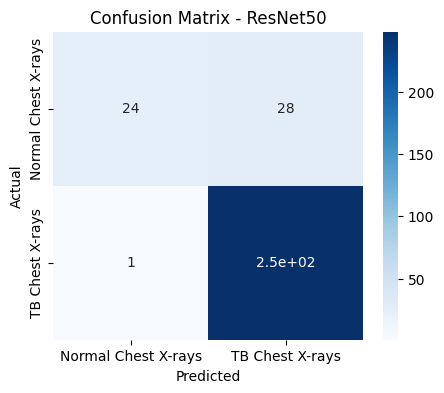

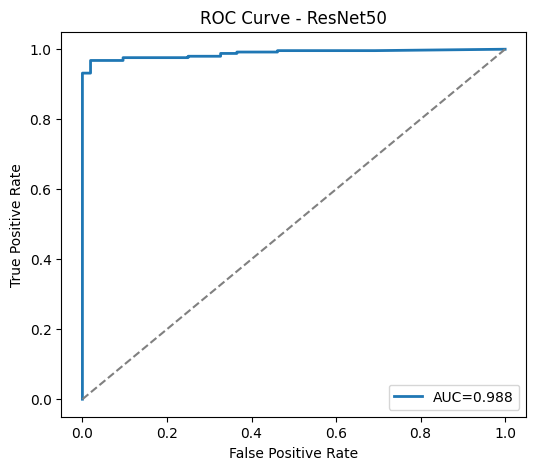


Evaluating VGG16
VGG16 Results → Acc=0.9900, Prec=0.9960, Rec=0.9920, F1=0.9940
10/10 [==============================] - 58s 6s/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.96      0.98      0.97        52
    TB Chest X-rays       1.00      0.99      0.99       249

           accuracy                           0.99       301
          macro avg       0.98      0.99      0.98       301
       weighted avg       0.99      0.99      0.99       301



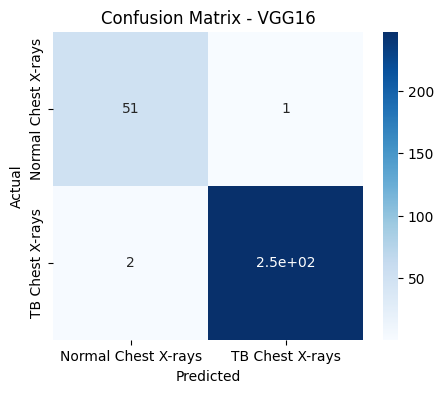

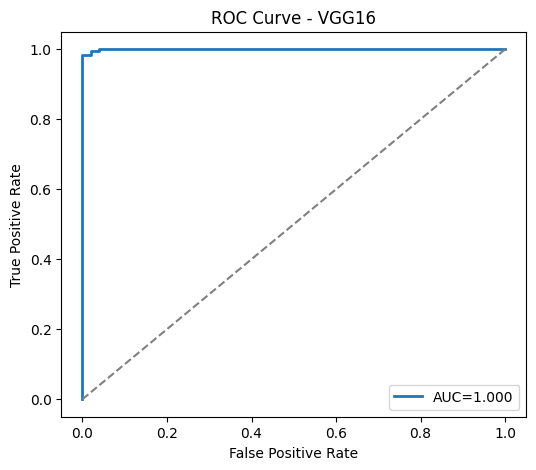


Evaluating EfficientNetB0
EfficientNetB0 Results → Acc=0.8272, Prec=0.8272, Rec=1.0000, F1=0.9055
10/10 [==============================] - 9s 569ms/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.00      0.00      0.00        52
    TB Chest X-rays       0.83      1.00      0.91       249

           accuracy                           0.83       301
          macro avg       0.41      0.50      0.45       301
       weighted avg       0.68      0.83      0.75       301



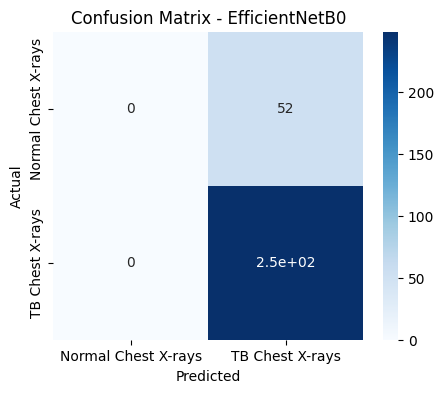

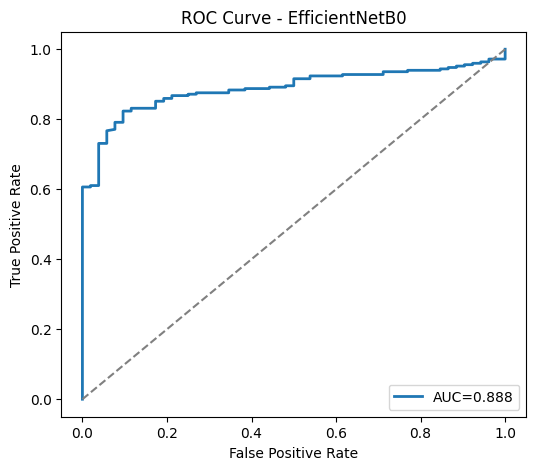


 FINAL MODEL COMPARISON
ResNet50: Acc=0.9037, F1=0.9448, AUC=0.9882
VGG16: Acc=0.9900, F1=0.9940, AUC=0.9996
EfficientNetB0: Acc=0.8272, F1=0.9055, AUC=0.8875


In [29]:
# EVALUATION


saved_model_files = {
    'ResNet50': "ResNet50.keras",
    'VGG16': "VGG16.keras",
    'EfficientNetB0': "EfficientNetB0.keras"
}

loaded_models = {}
for name, file in saved_model_files.items():
    print(f"\nLoading {name} from {file} ...")
    loaded_models[name] = tf.keras.models.load_model(
        file,
        custom_objects={'F1Score': F1Score}   # important!
    )

results = {}

for name, model in loaded_models.items():
    print("\n==============================")
    print(f"Evaluating {name}")
    print("==============================")

    # ---- Evaluate on test_ds ----
    loss, acc, prec, rec, f1 = model.evaluate(test_ds, verbose=0)
    print(f"{name} Results → Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    # ---- Predictions ----
    probs = model.predict(X_test, batch_size=32).ravel()
    preds = (probs >= 0.5).astype(int)

    # ---- Classification Report ----
    print("\nClassification Report:")
    print(classification_report(y_test, preds, target_names=CATEGORIES))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        xticklabels=CATEGORIES,
        yticklabels=CATEGORIES
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # ---- Save Results ----
    results[name] = {
        "test_acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc
    }

# ---- Final Summary ----
print("\n====================================")
print(" FINAL MODEL COMPARISON")
print("====================================")
for model_name, r in results.items():
    print(f"{model_name}: Acc={r['test_acc']:.4f}, F1={r['f1']:.4f}, AUC={r['roc_auc']:.4f}")
